In [1]:
import os
import shutil
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import cv2
import torch
import einops
import numpy as np
from PIL import Image
from pytorch_lightning import seed_everything
import torchvision.transforms as transformers

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/yfyuan/anaconda3/envs/semantic/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

In [3]:
from enum import Enum
from ControlNet.cldm.model import create_model,load_state_dict
from ControlNet.annotator.canny import CannyDetector
from ControlNet.annotator.hed import HEDdetector
from ControlNet.annotator.midas import MidasDetector

from ControlNet.annotator.util import HWC3
from safetensors.torch import load_file

from src.controller import AttentionControl
from src.ddim_v_hacked import DDIMVSampler
from src.img_util import find_flat_region, numpy2tensor

eta = 0.0

In [4]:
model_dict = {
    'Stable Diffusion 1.5': '/home/yfyuan/YYF/all_models/model.ckpt',
    'revAnimated_v11': 'models/revAnimated_v11.safetensors',
    'realisticVisionV20_v20': 'models/realisticVisionV20_v20.safetensors',
    'DGSpitzer/Cyberpunk-Anime-Diffusion': '~/YYF/all_models/Cyberpunk-Anime-Diffusion.safetensors',
    'wavymulder/Analog-Diffusion': 'analog-diffusion-1.0.safetensors',
    'Fictiverse/Stable_Diffusion_PaperCut_Model': '/home/yfyuan/YYF/all_models/papercut_v1.ckpt',
}
local_model = ['Fictiverse/Stable_Diffusion_PaperCut_Model', 'wavymulder/Analog-Diffusion', 'DGSpitzer/Cyberpunk-Anime-Diffusion']
class ProcessingState(Enum):
    NULL = 0
    FIRST_IMG = 1
    KEY_IMGS = 2
class GlobalState:

    def __init__(self):
        self.sd_model = None
        self.ddim_v_sampler = None
        self.detector_type = None
        self.detector = None
        self.controller = None
        self.processing_state = ProcessingState.NULL

    def update_controller(self, inner_strength, mask_period, cross_period,
                          ada_period, warp_period):
        self.controller = AttentionControl(inner_strength, mask_period,
                                           cross_period, ada_period,
                                           warp_period)

    def update_sd_model(self, sd_model, control_type):
        if sd_model == self.sd_model:
            return
        self.sd_model = sd_model
        model = create_model('./ControlNet/models/cldm_v15.yaml').cpu()
        if control_type == 'HED':
            # model.load_state_dict(
            #     load_state_dict(huggingface_hub.hf_hub_download(
            #         'lllyasviel/ControlNet', './models/control_sd15_hed.pth'),
            #         location=device))
            model.load_state_dict(
                load_state_dict('./models/control_sd15_hed.pth',
                                location=device))            
        elif control_type == 'canny':
            model.load_state_dict(
                load_state_dict('./models/control_sd15_canny.pth',
                                location=device))
        elif control_type == 'depth':
            model.load_state_dict(
                load_state_dict('./models/control_sd15_depth.pth',
                                location=device))

        model.to(device)
        sd_model_path = model_dict[sd_model]
        if len(sd_model_path) > 0:
            # check if sd_model is repo_id/name otherwise use global REPO_NAME
            if sd_model.count('/') == 1:
                repo_name = sd_model

            model_ext = os.path.splitext(sd_model_path)[1]
            if model_ext == '.safetensors':
                model.load_state_dict(load_file(sd_model_path), strict=False)
            elif model_ext == '.ckpt' or model_ext == '.pth':
                model.load_state_dict(torch.load(sd_model_path)['state_dict'],
                                      strict=False)

        try:
            model.first_stage_model.load_state_dict(torch.load('./models/vae-ft-mse-840000-ema-pruned.ckpt')['state_dict'],strict=False)
        except Exception:
            print('Warning: We suggest you download the fine-tuned VAE',
                  'otherwise the generation quality will be degraded')

        self.ddim_v_sampler = DDIMVSampler(model)

    def clear_sd_model(self):
        self.sd_model = None
        self.ddim_v_sampler = None
        if device == 'cuda':
            torch.cuda.empty_cache()

    def update_detector(self, control_type, canny_low=100, canny_high=200):
        if self.detector_type == control_type:
            return
        if control_type == 'HED':
            self.detector = HEDdetector()
        elif control_type == 'canny':
            canny_detector = CannyDetector()
            low_threshold = canny_low
            high_threshold = canny_high

            def apply_canny(x):
                return canny_detector(x, low_threshold, high_threshold)

            self.detector = apply_canny

        elif control_type == 'depth':
            midas = MidasDetector()

            def apply_midas(x):
                detected_map, _ = midas(x)
                return detected_map

            self.detector = apply_midas

In [5]:
global_state = GlobalState()

In [6]:
# sd_model = 'Stable Diffusion 1.5'
sd_model = 'revAnimated_v11'
# sd_model = 'realisticVisionV20_v20' #真实风格
# sd_model = 'DGSpitzer/Cyberpunk-Anime-Diffusion' #赛博朋克风格
# sd_model = 'wavymulder/Analog-Diffusion' # 人物传记风格
# sd_model = 'Fictiverse/Stable_Diffusion_PaperCut_Model' # 剪纸风格
control_type = 'canny'
low_threshold = 50
high_threshold = 100

In [7]:
global_state.update_sd_model(sd_model, control_type)
global_state.update_controller(0,0,0,0,0)
global_state.update_controller(0,0,0,0,0)
global_state.update_detector(control_type, low_threshold, high_threshold)

ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.5.mlp.fc1.bias', 'vision_model.encoder.layers.23.mlp.fc2.bias', 'vision_model.encoder.layers.6.self_attn.v_proj.bias', 'vision_model.encoder.layers.14.self_attn.q_proj.bias', 'vision_model.encoder.layers.14.mlp.fc2.bias', 'vision_model.encoder.layers.19.self_attn.v_proj.weight', 'vision_model.encoder.layers.4.layer_norm2.weight', 'vision_model.encoder.layers.18.mlp.fc2.bias', 'vision_model.encoder.layers.22.self_attn.v_proj.bias', 'vision_model.encoder.layers.20.self_attn.k_proj.weight', 'vision_model.encoder.layers.21.self_attn.out_proj.weight', 'vision_model.encoder.layers.16.mlp.fc1.weight', 'vision_model.encoder.layers.23.mlp.fc1.bias', 'vision_model.encoder.layers.16.self_attn.q_proj.bias', 'vision_model.encoder.layers.18.layer_norm1.bias', 'vision_model.encoder.layers.14.mlp.fc1.weight', 'vision_model.encoder.layers.2.layer_norm1.weigh

Loaded model config from [./ControlNet/models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_canny.pth]


In [8]:
def save_feature_maps(blocks, i, feature_type="input_block"):
    block_idx = 0
    for block in blocks:
        if feature_type == "input_block":
            if "Downsample" in str(type(block[0])) and block_idx == 6:
                save_feature_map(block[0].down_output_feature,
                                 f"down_output_{block_idx}_time_{0}")
        elif feature_type == "output_block":
           
            if "ResBlock" in str(type(block[0])) and block_idx == 5:
                save_feature_map(block[0].out_layers_features,
                                 f"{feature_type}_{block_idx}_out_layers_features_time_{0}")
                
            if len(block) > 1 and "SpatialTransformer" in str(type(block[1])) and block_idx in [3,4,5,6,7,8]: # block:[resblock, spatial]
                save_feature_map(block[1].transformer_blocks[0].attn1.tmp_sim, f"attn_{block_idx}_frame_{0}")
        block_idx += 1

    # block_idx = 0
    # for block in blocks:
    #     if feature_type == "input_block":
    #         if "Downsample" in str(type(block[0])) and block_idx:
    #             save_feature_map(block[0].down_output_feature,
    #                              f"down_output_{block_idx}_time_{0}")
    #         if len(block) > 1 and "SpatialTransformer" in str(type(block[1])):
    #             save_feature_map(block[1].attention_output,
    #                              f"down_output_{block_idx}_time_{0}")
    #     elif feature_type == "output_block":

    #         if "ResBlock" in str(type(block[0])):
    #             save_feature_map(block[0].out_layers_features,
    #                              f"{feature_type}_{block_idx}_out_layers_features_time_{0}")

    #         if len(block) > 1 and "SpatialTransformer" in str(type(block[1])):  # block:[resblock, spatial]
    #             save_feature_map(block[1].transformer_blocks[0].attn1.tmp_sim, f"attn_{block_idx}_frame_{0}")
    #     block_idx += 1
        
def save_feature_maps_callback(i, unet_model):
    save_feature_maps(unet_model.input_blocks, i, "input_block")
    save_feature_maps(unet_model.output_blocks, i, "output_block")

def save_feature_map(feature_map, filename):
    os.makedirs(feature_maps_path, exist_ok=True)
    save_path = os.path.join(feature_maps_path, f"{filename}.pt")
    torch.save(feature_map, save_path)

In [9]:
@torch.no_grad()
def single_inversion(x0, ddim_v_sampler, img_callback=None):
    steps = 1000
    model = ddim_v_sampler.model

    prompt = f""
    cond = {
        'c_concat': None,
        'c_crossattn': [
            model.get_learned_conditioning(
                [prompt]
            )
        ]
    }
    un_cond = {
        'c_concat': None,
        'c_crossattn': [
            model.get_learned_conditioning(
                ['']
            )
        ]
    }
    ddim_v_sampler.encode_ddim(x0, steps, cond, un_cond, img_callback=img_callback)
    
    
def resize_image(input_image, resolution):
    H, W, C = input_image.shape
    H = float(H)
    W = float(W)
    k = min(float(resolution) / min(H, W), float(768) / max(H, W))
    H *= k
    W *= k
    H = int(np.round(H / 64.0)) * 64
    W = int(np.round(W / 64.0)) * 64
    img = cv2.resize(
        input_image, (W, H),
        interpolation=cv2.INTER_LANCZOS4 if k > 1 else cv2.INTER_AREA)
    return img


l, r, t, b = (0, 0, 0, 0)
resolution = 512

def crop_func(frame):
    H, W, C = frame.shape
    left = np.clip(l, 0, W)
    right = np.clip(W - r, left, W)
    top = np.clip(t, 0, H)
    bottom = np.clip(H - b, top, H)
    frame = frame[top:bottom, left:right]
    return resize_image(frame, resolution)

In [10]:
%%capture
ddim_v_sampler = global_state.ddim_v_sampler
model = ddim_v_sampler.model
detector = global_state.detector
controller = global_state.controller
model.control_scales = [0.9] * 13
model.to(device)
                                                                                                                        

In [11]:
# face_dir = "/mnt/pami23/yfyuan/DATASET/FFHQ_1024x1024/19363.png"
# # face_dir = "/mnt/local1_ssd/zzhuang/DATASET/celeba-hq/celeba-512/072537.jpg" #好图
# # face_dir = "/mnt/pami23/yfyuan/DATASET/afhq/val/dog/pixabay_dog_000618.jpg"
# coco_dir = "/mnt/local1_ssd/zzhuang/DATASET/COCO/val2017/000000082180.jpg"
# print(cv2.imread(coco_dir).shape)
# display(Image.open(face_dir).resize((512,512)))

In [12]:
######### 批量出图  ##########
dir_list = os.listdir("/home/yfyuan/YYF/Rerender/exp/ImageNet/imagenet-r")
first_strength = 1 - 0.6

processed = [dir_name[:-len("realisticVisionV20_v20_20")-1] for dir_name in os.listdir("/home/yfyuan/YYF/Rerender/exp/ImageNet/results")]

# prompt = "realistic photo"
# a_prompt = "RAW photo, subject, (high detailed skin:1.2), 8k uhd, dslr, soft lighting, high quality, film grain"
# n_prompt = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime, mutated hands and fingers:1.4), (deformed, distorted, disfigured:1.3), poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, disconnected limbs, mutation, mutated, ugly, disgusting, amputation"

# prompt = "realistic photo"
# a_prompt = "yellow, RAW photo, subject, (high detailed skin:1.2), 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3"
# n_prompt = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime, mutated hands and fingers:1.4), (deformed, distorted, disfigured:1.3), poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, disconnected limbs, mutation, mutated, ugly, disgusting, amputation"

# prompt = "((Papercut)), shapes, delicate patterns, silhouette, kirigami, sharp outline, Spread the picture"
# a_prompt = "(masterpiece, top quality, best quality)"
# n_prompt = "frame,decorations"

# prompt = "in cartoon sytle"
# a_prompt = "RAW photo, subject, (high detailed skin:1.2), 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3"
# n_prompt = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime, mutated hands and fingers:1.4), (deformed, distorted, disfigured:1.3), poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, disconnected limbs, mutation, mutated, ugly, disgusting, amputation"

prompt = "in CG style"
a_prompt = "extremely detailed"
n_prompt = "extra digit, fewer digits, cropped, worst quality, low quality"

# prompt = "wartercolor"
# a_prompt = "high detailed,  pixiv, art station"
# n_prompt = " ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, bad anatomy, watermark, signature, cut off, low contrast, underexposed, overexposed, bad art, beginner, amateur, distorted face"

# prompt = "in anime style"
# a_prompt = "high detailed,  pixiv, art station"
# n_prompt = "extra digit, fewer digits, cropped, worst quality, low quality"

# prompt = "Papercut"
# a_prompt = "high detailed,  pixiv, art station"
# n_prompt = "extra digit, fewer digits, cropped, worst quality, low quality"

Global seed set to 0
Global seed set to 0


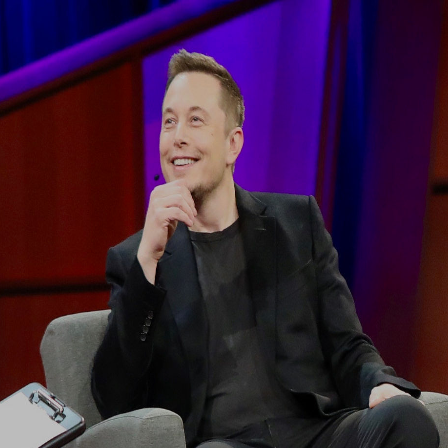

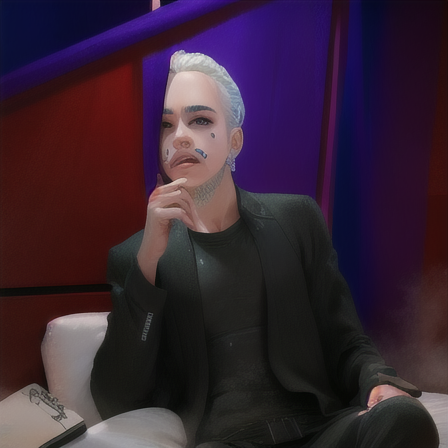

Global seed set to 0


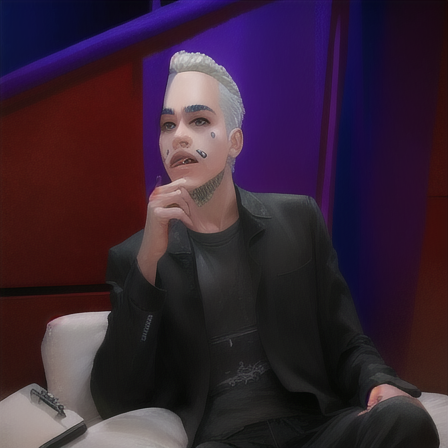

Global seed set to 0


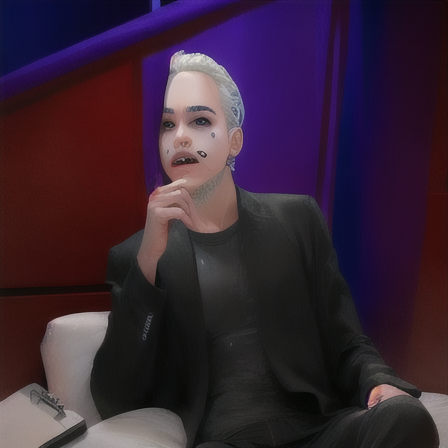

Global seed set to 0


RuntimeError: einsum(): subscript j has size 3136 for operand 1 which does not broadcast with previously seen size 4928

In [13]:
# 0 5 8 9
seed = 0
dir_ = "human"
img_name = "1013321719932803_.pic.jpg"
seed_everything(seed)
from tqdm.notebook import tqdm
num_samples = 1
steps = 20
unet_model = model.model.diffusion_model
img_dir = f"/home/yfyuan/DATASET/{dir_}"
feature_maps_path = "/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn"
feature_maps_path_denoising = os.path.join(feature_maps_path, f"{dir_}")
feature_maps_path_inv = os.path.join(feature_maps_path, f"{dir_}_inv_2")

img_path = os.path.join(img_dir, img_name)

# img_path = "/home/yfyuan/YYF/Rerender/result/pexels-koolshooters-7322716/video/0001.png"
# img_name = "woman.jpg"
# img_path = face_dir
# dir_ = "women"

results = "/home/yfyuan/YYF/Rerender/result/layer_cmp"

controller.set_task('')
with torch.no_grad():
    def ddim_sampler_callback(i):
        save_feature_maps_callback(i, unet_model)
    def generate_first_img(x0, img, strength):
        samples, _ = ddim_v_sampler.sample(
            steps,
            num_samples,
            shape,
            cond,
            verbose=False,
            eta=eta,
            unconditional_guidance_scale=7.5,
            unconditional_conditioning=un_cond,
            controller=controller,
            x0=x0,
            strength=strength,
            img_callback=None)
        x_samples = model.decode_first_stage(samples)
        x_samples_np = (
                einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 +
                127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
        return x_samples, x_samples_np
    
    seed_everything(seed)
    ###################### Reference Image ##############################
    frame = cv2.imread(img_path)
    if(frame.shape[0] ==1024 or frame.shape[1] == 1024):
        frame = cv2.resize(frame,(500,500))
    shape = frame.shape
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = np.array(transformers.CenterCrop((frame.shape[0] // 64 * 64, frame.shape[1] // 64 * 64))(Image.fromarray(frame)))
    display(Image.fromarray(frame))
    # frame = crop_func(frame)

    img = HWC3(frame)
    H, W, C = img.shape
    shape = (4, H // 8, W // 8)
    img_ = numpy2tensor(img)
    encoder_posterior = model.encode_first_stage(img_.to(device))
    x0 = model.get_first_stage_encoding(encoder_posterior).detach()
    ###################### ControlNet ###################################
    
    control = None
    detected_map = detector(img)
    detected_map = HWC3(detected_map)    
    control = torch.from_numpy(detected_map.copy()).float().to(device) / 255.0
    control = torch.stack([control for _ in range(num_samples)], dim=0)
    control = einops.rearrange(control, 'b h w c -> b c h w').clone()
    
    
    cond = {
        'c_concat': [control],
        'c_crossattn': [
            model.get_learned_conditioning(
                [prompt + ', ' + a_prompt] * num_samples)
        ],
    }
    un_cond = {
        'c_crossattn':
            [model.get_learned_conditioning([n_prompt] * num_samples)],
        'c_concat': [control],
    }
    
# # #     ################### DDIM Inversion ###################################
    unet_model.unet_type = "denoising"
    feature_maps_path = feature_maps_path_inv
    single_inversion(x0, ddim_v_sampler, ddim_sampler_callback)
# # #     ############################ SD #######################################
#     seed_everything(seed)
#     x_samples, x_samples_np = generate_first_img(x0, img, first_strength)
#     display(Image.fromarray(x_samples_np[0]))
#     Image.fromarray(x_samples_np[0]).save(f"/home/yfyuan/YYF/Rerender/exp/exp_controlnet/{dir_}_{control_type}_sd.png")
#     # Image.fromarray(x_samples_np[0]).save(f"/home/yfyuan/YYF/Rerender/exp/exp_controlnet/{dir_}_none_ctrl_{1-first_strength}_sd.png")
# # #     ########################### Ours #################################################
    
    # seed_everything(0)
    # controller.set_task(['initfirst'])
    # # attn
    unet_model.batch_frame_attn_feature_path = feature_maps_path
    controller.batch_frame_attn_feature_path = feature_maps_path
    # controller.threshold_block_idx = [3,4,5]

#     # unet_model.unet_type = "spatial"

#     x_samples, x_samples_np = generate_first_img(x0, img, first_strength)
#     display(Image.fromarray(x_samples_np[0]))
#     Image.fromarray(x_samples_np[0]).save(f"/home/yfyuan/YYF/Rerender/exp/exp_controlnet/{dir_}_none_ctrl_{1-first_strength}_ours.png")
#     controller.set_task("")

    controller.set_task('')
    unet_model.unet_type = "denoising"
    # seed_everything(seed)
    x_samples, x_samples_np = generate_first_img(x0, img, first_strength)
    display(Image.fromarray(x_samples_np[0]))

    # controller.set_task('initfirst')
    # controller.threshold_block_idx = [1,2]
    # # seed_everything(seed)
    # x_samples, x_samples_np = generate_first_img(x0, img, first_strength)
    # display(Image.fromarray(x_samples_np[0]))
    # controller.set_task('')

    # controller.set_task('')
    # x_samples, x_samples_np = generate_first_img(x0, img, first_strength)
    # display(Image.fromarray(x_samples_np[0]))


    controller.set_task('initfirst')
    controller.threshold_block_idx = [3, 4, 5]
    seed_everything(0)
    x_samples, x_samples_np = generate_first_img(x0, img, first_strength)
    Image.fromarray(x_samples_np[0]).save(os.path.join(results, img_name[:-4] + f"_attn{''.join(map(str,controller.threshold_block_idx))}.jpg"))
    display(Image.fromarray(x_samples_np[0]))
    controller.set_task('')


    controller.set_task('initfirst')
    controller.threshold_block_idx = [5, 6, 7]
    seed_everything(0)
    x_samples, x_samples_np = generate_first_img(x0, img, first_strength)
    Image.fromarray(x_samples_np[0]).save(os.path.join(results, img_name[:-4] + f"_attn{''.join(map(str,controller.threshold_block_idx))}.jpg"))
    display(Image.fromarray(x_samples_np[0]))
    controller.set_task('')
    
    controller.set_task('initfirst')
    controller.threshold_block_idx = [5, 6, 7, 8, 9]
    seed_everything(0)
    x_samples, x_samples_np = generate_first_img(x0, img, first_strength)
    Image.fromarray(x_samples_np[0]).save(
        os.path.join(results, img_name[:-4] + f"_attn{''.join(map(str, controller.threshold_block_idx))}.jpg"))
    display(Image.fromarray(x_samples_np[0]))
    controller.set_task('')
    
    # controller.set_task('initfirst')
    # controller.threshold_block_idx = [1, 2]
    # seed_everything(0)
    # x_samples, x_samples_np = generate_first_img(x0, img, first_strength)
    # Image.fromarray(x_samples_np[0]).save(
    #     os.path.join(results, img_name[:-4] + f"_attn{''.join(map(str, controller.threshold_block_idx))}.jpg"))
    # display(Image.fromarray(x_samples_np[0]))
    # controller.set_task('')

In [ ]:
controller.batch_frame_attn_feature_path

In [12]:
unet_model.unet_type

'denoising'

In [55]:
# Image.fromarray(x_samples_np[0]).save(f"/home/yfyuan/YYF/Rerender/exp/exp_controlnet/{dir_}_{control_type}_sd.png")
Image.fromarray(x_samples_np[0]).save(f"/home/yfyuan/YYF/Rerender/exp/exp_controlnet/{dir_}_{control_type}_ours.png")


# Image.fromarray(frame).save(f"/home/yfyuan/YYF/Rerender/exp/exp_controlnet/{dir_}.png")
# Image.fromarray(detected_map).save(f"/home/yfyuan/YYF/Rerender/exp/exp_controlnet/{dir_}_{control_type}.png")

In [56]:
Image.fromarray(x_samples_np).save(f"/home/yfyuan/YYF/Rerender/exp/exp_controlnet/{dir_}_{control_type}_sd.png")
# Image.fromarray(x_samples_np).save(f"/home/yfyuan/YYF/Rerender/exp/exp_seed/{dir_}_{seed}_sd.png")
# Image.fromarray(x_samples_np[0]).save(f"/home/yfyuan/YYF/Rerender/exp/exp_seed/{dir_}_{seed}_ours.png")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/yfyuan/anaconda3/envs/v2v/lib/python3.8/site-packages/PIL/Image.py:3080 in fromarray       │
│                                                                                                  │
│   3077 │   │   │   msg = "Cannot handle this data type"                                          │
│   3078 │   │   │   raise TypeError(msg) from e                                                   │
│   3079 │   │   try:                                                                              │
│ ❱ 3080 │   │   │   mode, rawmode = _fromarray_typemap[typekey]                                   │
│   3081 │   │   except KeyError as e:                                                             │
│   3082 │   │   │   msg = "Cannot handle this data type: %s, %s" % typekey                        │
│   3083 │   │   │   raise TypeError(msg) from e                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: ((1, 1, 320, 3), '|u1')

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 Image.fromarray(x_samples_np).save(f"/home/yfyuan/YYF/Rerender/exp/exp_controlnet/{dir_}     │
│   2 # Image.fromarray(x_samples_np).save(f"/home/yfyuan/YYF/Rerender/exp/exp_seed/{dir_}_{se     │
│   3 # Image.fromarray(x_samples_np[0]).save(f"/home/yfyuan/YYF/Rerender/exp/exp_seed/{dir_}_     │
│   4                                                                                              │
│                                                                                                  │
│ /home/yfyuan/anaconda3/envs/v2v/lib/python3.8/site-packages/PIL/Image.py:3083 in fromarray       │
│                                                                                                  │
│   3080 │   │   │   mode, rawmode = _fromarray_typemap[typekey]                                   │
│   3081 │   │   except KeyError as e:                                                             │
│   3082 │   │   │   msg = "Cannot handle this data type: %s, %s" % typekey                        │
│ ❱ 3083 │   │   │   raise TypeError(msg) from e                                                   │
│   3084 │   else:                                                                                 │
│   3085 │   │   rawmode = mode                                                                    │
│   3086 │   if mode in ["1", "L", "I", "P", "F"]:                                                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: Cannot handle this data type: (1, 1, 320, 3), |u1

In [29]:
a = 'initfirst'
'initfirst' in a
    

True

In [33]:
controller.threshold_block_idx

[3, 4]

In [25]:
''.join(map(str, [1,2,3,4]))

'1234'